In [1]:
import os
import json
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset
import albumentations as A

In [2]:
from src.display import plot_boxes, plot_img_seg, plot_image, plot_boxes_instance_masks

In [3]:
PATH = "data/VOCdevkit/VOC2012"

In [4]:
class PascalDataset(Dataset):
    def __init__(self, json_path="data/annotations.json", size=320):
        self.image_path = "data/VOCdevkit/VOC2012/JPEGImages"
        self.seg_path = "data/VOCdevkit/VOC2012/SegmentationObject"

        with open(json_path, "r") as fp:
            data = json.load(fp)
        self.data = data
        
        self.mean = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
        self.std = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))
        
        self.crop = A.Compose([
            A.RandomCrop(width=size, height=size, p=1)
        ], bbox_params=A.BboxParams(format="pascal_voc", label_fields=["class_idxs", "names", "seg_ids"]))

    def __len__(self):
        return len(self.data)
    
    def crop_img(self, img, seg_img, bboxes, class_idxs, names, seg_ids):
        t = self.crop(image=img,
                      mask=seg_img,
                      bboxes=bboxes.tolist(),
                      class_idxs=class_idxs.tolist(),
                      names=names,
                      seg_ids=seg_ids.tolist()
                    )
        
        img = t["image"]
        seg_img = t["mask"]
        bboxes = np.array(t["bboxes"], dtype=int)
        class_idxs = np.array(t["class_idxs"])
        names = t["names"]
        seg_ids = np.array(t["seg_ids"])

        return img, seg_img, bboxes, class_idxs, names, seg_ids

    def get_plotting_item(self, idx):
        d = self.data[idx]

        img = cv2.imread(os.path.join(self.image_path, d["file_name"]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.uint8)
        seg_img = cv2.imread(os.path.join(self.seg_path, d["seg_file_name"]), cv2.IMREAD_GRAYSCALE)
        
        seg_img = np.repeat(seg_img[:, :, np.newaxis], 3, axis=2)

        bboxes = np.array([a["bbox"] for a in d["annotations"]])
        class_idxs = np.array([a["class_idx"] for a in d["annotations"]])
        names = [a["class_name"] for a in d["annotations"]]
        
        seg_ids = np.array([a["seg_mask_id"] for a in d["annotations"]], dtype=np.uint8)

        return img, seg_img, bboxes, class_idxs, names, seg_ids
    
    def __getitem__(self, idx):
        img, seg_img, bboxes, class_idxs, names, seg_ids = self.get_plotting_item(idx)
        
        img, seg_img, bboxes, class_idxs, names, seg_ids = self.crop_img(img,
                                                                         seg_img,
                                                                         bboxes,
                                                                         class_idxs,
                                                                         names,
                                                                         seg_ids)

        img = np.transpose(img, (2, 0, 1))
        img = img / 255.0
        img = (img - self.mean) / self.std
        img = torch.from_numpy(img).unsqueeze(0)

        seg_img = torch.from_numpy(seg_img).float().unsqueeze(0)       

        bboxes = torch.from_numpy(bboxes).float().unsqueeze(0)
        class_idxs = torch.from_numpy(class_idxs).float().unsqueeze(0)
        seg_ids = torch.from_numpy(seg_ids).unsqueeze(0)

        return img, seg_img, bboxes, class_idxs, seg_ids

In [5]:
ds = PascalDataset()

In [6]:
ds[0]

(tensor([[[[-1.3644, -1.3302, -1.2959,  ..., -0.5938, -0.4226, -0.0801],
           [-0.6109, -0.6281, -0.5938,  ..., -0.7822, -0.6109, -0.2684],
           [-1.2617, -1.2274, -1.1418,  ..., -0.8164, -0.6623, -0.2684],
           ...,
           [-1.4500, -1.5699,  0.0912,  ..., -0.6281, -0.6109, -0.5253],
           [-1.4329, -0.1486,  1.7694,  ..., -0.6794, -0.5938, -0.5596],
           [-1.4158, -1.1075, -0.8678,  ..., -0.8164, -0.6109, -0.6109]],
 
          [[-1.5280, -1.4930, -1.4580,  ..., -0.9328, -1.0378, -0.9328],
           [-0.6001, -0.6176, -0.5826,  ..., -1.0728, -1.1779, -1.0903],
           [-1.1779, -1.1604, -1.0728,  ..., -1.0728, -1.1429, -0.9853],
           ...,
           [-1.2479, -1.5980, -0.3025,  ..., -1.6155, -1.6856, -1.4230],
           [-1.7031, -0.8627,  0.8880,  ..., -1.5630, -1.7731, -1.5105],
           [-1.5455, -1.7731, -1.9657,  ..., -1.5105, -1.7206, -1.4930]],
 
          [[-1.6650, -1.6302, -1.6302,  ..., -1.1421, -1.2467, -1.1421],
           [-

In [7]:
ds.data[0]

{'file_name': '2011_001665.jpg',
 'seg_file_name': '2011_001665.png',
 'id': '2011_001665',
 'height': '333',
 'width': '500',
 'annotations': [{'class_name': 'chair',
   'class_idx': 9,
   'bbox': [99, 129, 168, 195],
   'seg_mask_id': 38},
  {'class_name': 'chair',
   'class_idx': 9,
   'bbox': [4, 129, 81, 271],
   'seg_mask_id': 75},
  {'class_name': 'diningtable',
   'class_idx': 11,
   'bbox': [47, 174, 500, 333],
   'seg_mask_id': 113},
  {'class_name': 'chair',
   'class_idx': 9,
   'bbox': [161, 120, 229, 183],
   'seg_mask_id': 14},
  {'class_name': 'diningtable',
   'class_idx': 11,
   'bbox': [59, 124, 252, 196],
   'seg_mask_id': 52},
  {'class_name': 'chair',
   'class_idx': 9,
   'bbox': [1, 209, 55, 333],
   'seg_mask_id': 89},
  {'class_name': 'chair',
   'class_idx': 9,
   'bbox': [264, 103, 294, 154],
   'seg_mask_id': 128},
  {'class_name': 'chair',
   'class_idx': 9,
   'bbox': [445, 92, 489, 181],
   'seg_mask_id': 19},
  {'class_name': 'chair',
   'class_idx': 9,

In [8]:
img, seg_img, bboxes, class_idxs, names, seg_ids = ds.get_plotting_item(1)

In [9]:
img, seg_img, bboxes, class_idxs, names, seg_ids = ds.crop_img(img, seg_img, bboxes, class_idxs, names, seg_ids)

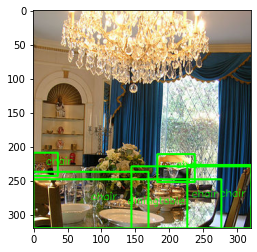

In [10]:
plot_img = plot_boxes(img, bboxes, names)
plot_image(plot_img)

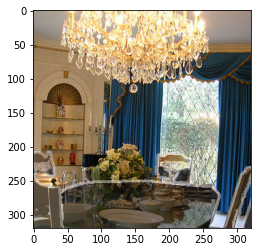

In [11]:
plot_img = plot_img_seg(img, seg_img, (seg_img > 0).astype(np.uint8))
plot_image(plot_img)

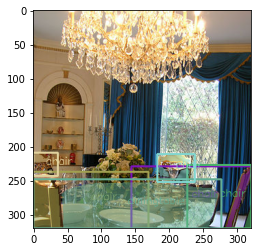

In [12]:
plot_img = plot_boxes_instance_masks(img, seg_img, bboxes, names, seg_ids)
plot_image(plot_img)